# Tarea 3: Modelo de recomendación de compra

Modelo de Machine Learning supervisado y de clasificación binaria.
1 significa que el cliente compra (true)
0 Significa que el cliente no compra (false)

## import Libraries

In [3]:
!pip install graphviz

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

PREPARE_PREDICTION = False


## Import Files

In [5]:
products = pd.read_csv("data/products_df.csv", encoding='utf-8')
products.drop(columns=['Unnamed: 0'], inplace=True)

commercial_activity = pd.read_csv("data/commercial_activity_df.csv", encoding='utf-8')
commercial_activity.drop(columns=['Unnamed: 0'], inplace=True)

sociodemographic = pd.read_csv("data/sociodemographic_df.csv", encoding='utf-8')
sociodemographic.drop(columns=['Unnamed: 0'], inplace=True)

# Realizamos un merge de los 3 datasets

In [6]:
df_join = pd.merge( products, commercial_activity, on = ['pk_cid','pk_partition'] )
df_join = pd.merge( df_join, sociodemographic, on=['pk_cid','pk_partition'] )

# Nombramos las variables booleanas True/False

In [7]:
boolean_cols = ["short_term_deposit", "loans", "mortgage", "funds", "securities",
                "long_term_deposit", "em_account_pp","credit_card", 
                "payroll_account", "emc_account", "debit_card", "em_account_p", 
                "em_acount", "payroll", "pension_plan"]
for x in boolean_cols:
    df_join[x] = df_join[x].astype(bool)

In [8]:
df_join.head(2).T

,0,1
pk_cid,1375586,1050611
pk_partition,2018-01-28,2018-01-28
short_term_deposit,False,False
loans,False,False
mortgage,False,False
funds,False,False
securities,False,False
long_term_deposit,False,False
em_account_pp,False,False
credit_card,False,False


## Eliminamos los datasets anteriores: products, commercial_activity, sociodemographic

In [9]:
del commercial_activity, products, sociodemographic

## 
   1. Asignamos la variable a predecir sobre la partition.
   2. Nombramos una lista de los productos
   3. Damos una variable a nuestros productos 
   4. Asignamos el precio a cada variable de productos 

In [10]:
partitions = ['2018-01-28',
              '2018-02-28',
              '2018-03-28',
              '2018-04-28',
              '2018-05-28',
              '2018-06-28',
              '2018-07-28',
              '2018-08-28',
              '2018-09-28',
              '2018-10-28',
              '2018-11-28',
              '2018-12-28',
              '2019-01-28',
              '2019-02-28',
              '2019-03-28',
              '2019-04-28',
              '2019-05-28']

products_list = ['short_term_deposit','loans','mortgage','funds','securities','long_term_deposit',
                 'em_account_pp','credit_card','pension_plan',
                 'payroll_account','emc_account','debit_card','em_account_p','em_acount']

products_3 = {"short_term_deposit":"inversión", "loans":"prestamo", "mortgage":"prestamo", 
              "funds":"inversión", "securities":"inversión", "long_term_deposit":"inversión", 
              "em_account_pp":"cuenta", "credit_card":"prestamo", "payroll_account":"cuenta", 
              "pension_plan":"inversión", "emc_account":"cuenta", "debit_card":"prestamo", 
              "em_account_p":"cuenta", "em_acount":"cuenta"}

product_values = {'cuenta':10, 'inversión':40, 'prestamo':60}

# Preparamos la Data 

Queremos predecir cuando un usuario da el alta de un producto según la partition.
- 1 si se da de alta
- 0 si no se da de alta

In [11]:
def determinar_altas(data):
    data.columns=['pk_partition','pk_cid','product']
    data['prev'] = data.groupby('pk_cid')['product'].shift(1)
    data['diff'] = data['product'] - data['prev']

    # Solo queremos 1 
    data['diff'] = np.where( (data['product']==1) & (data['diff'].isna()) & (data['pk_partition']!='2018-01-28'), 1, data['diff'] )
    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == -1, 0, data['diff'] )

    return data['diff']

In [12]:
def determinar_bajas(data):
    data.columns=['pk_partition','pk_cid','product']
    data['prev'] = data.groupby('pk_cid')['product'].shift(1)
    data['diff'] = data['product'] - data['prev']

    # Solo queremos -1 pero los codificamos como 1 (más facil) 
    data['diff'] = np.where( (data['product']==1) & (data['diff'].isna()) & (data['pk_partition']!='2018-01-28'), 1, data['diff'] )
    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == 0, 0, data['diff'] )
    data['diff'] = np.where( data['diff'] == -1, 1, data['diff'] )

    return data['diff']

In [13]:
df = df_join.copy(deep=True)

In [14]:
for prod in products_list:
    df[prod+'_altas'] = determinar_altas( df_join[['pk_partition','pk_cid',prod]] )
    df[prod+'_bajas'] = determinar_bajas( df_join[['pk_partition','pk_cid',prod]] )
    print(prod)

short_term_deposit
loans
mortgage
funds
securities
long_term_deposit
em_account_pp
credit_card
pension_plan
payroll_account
emc_account
debit_card
em_account_p
em_acount


## Total altas

In [15]:

products_3_2 = {"short_term_deposit":"inversión", "loans":"prestamo", "mortgage":"prestamo", 
    "funds":"inversión", "securities":"inversión", "long_term_deposit":"inversión", 
    "em_account_pp":"cuenta", "credit_card":"prestamo", "payroll_account":"cuenta", "pension_plan":"inversión", 
    "emc_account":"cuenta", "debit_card":"prestamo", "em_account_p":"cuenta", "em_acount":"cuenta"}


init_cols = ['total_altas_cuenta','total_altas_inversión','total_altas_prestamo',
    'altas_cuenta','altas_inversión','altas_prestamo',
    'total_bajas_cuenta','total_bajas_inversión','total_bajas_prestamo'] 


for col in init_cols:
    df[col] = 0

for key, value in products_3_2.items():
    df['total_altas_'+value] += df[key+'_altas']
    df['altas_'+value] +=  df['total_altas_'+value]
    df['total_bajas_'+value] += df[key+'_bajas']

    # memory optimization
    df['altas_'+value] = df['total_altas_'+value].astype('int8')
    df['total_altas_'+value] = df['total_altas_'+value].astype('int8')
    df['total_altas_'+value] = df['total_bajas_'+value].astype('int8')

    df.drop([key+'_bajas',key+'_altas'], axis=1, inplace=True)

df['total_altas'] = df['total_altas_cuenta'] + df['total_altas_inversión'] + df['total_altas_prestamo']
df['total_bajas'] = df['total_bajas_cuenta'] + df['total_bajas_inversión'] + df['total_bajas_prestamo']

In [16]:
df['total'] = df['altas_cuenta'] + df['altas_inversión'] + df['altas_prestamo']

In [17]:
df = df.sort_values(['pk_cid','pk_partition'])
df.head(3).T

,1479563,2168122,2962973
pk_cid,15891,15891,16063
pk_partition,2018-07-28,2018-08-28,2018-11-28
short_term_deposit,False,False,False
loans,False,False,False
mortgage,False,False,False
funds,False,False,False
securities,False,False,False
long_term_deposit,False,False,False
em_account_pp,False,False,False
credit_card,False,False,False


## convertimos la variable de tiempo "pk_partition

In [18]:
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

In [19]:
#df.info

## Convertimos las variables a valor númerico    

In [20]:
le = LabelEncoder()
le.fit(df['entry_channel'])
df['entry_channel'] = le.transform(df['entry_channel'])

In [21]:
le = LabelEncoder()
le.fit(df['gender'])
df['gender'] = le.transform(df['gender'])


In [22]:
del le

## Altas y bajas de los principales productos en los ultimos meses

In [23]:
def rolling_shift(df, col, window, calc):
    if calc == 'sum':
        rolling = df.groupby('pk_cid')[[col]].rolling(window = window, min_periods=1).sum()
    elif calc == 'max':
        rolling = df.groupby('pk_cid')[[col]].rolling(window = window, min_periods=1).max()
    
    rolling.reset_index(inplace=True)
    rolling['shift'] = rolling.groupby('pk_cid')[[col]].shift(1)
    rolling[col].fillna(0,inplace=True)
    rolling[col] = rolling[col].astype('int')
        
    return rolling[col]

In [24]:
bajas_shifts = []

transf = {'1m':1,'3m':3}
cols = ['total_bajas','total_bajas_cuenta','total_bajas_inversión','total_bajas_prestamo']


for total in cols:
    for key, window in transf.items():
        if window == 1:
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
        else:
            df[total] = rolling_shift(df, total, window, 'sum')
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
            
        df[total+'_'+key+'_shift'].fillna(0, inplace=True)
        df[total+'_'+key+'_shift'] = df[total+'_'+key+'_shift'].astype('int8')
    
        bajas_shifts.append(total+'_'+key+'_shift')

    print(total)
    df.drop(total, axis=1, inplace=True)


total_bajas
total_bajas_cuenta
total_bajas_inversión
total_bajas_prestamo


In [25]:
altas_shifts = []

transf = {'1m':1,'2m':2,'3m':3,'6m':6}
cols = ['total_altas','total_altas_cuenta','total_altas_inversión','total_altas_prestamo']

for total in cols:
    for key, window in transf.items():
        if window == 1:
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
        else:
            df[total] = rolling_shift(df, total, window, 'sum')
            if PREPARE_PREDICTION:
                df[total+'_'+key+'_shift'] = df[total]
            else:
                df[total+'_'+key+'_shift'] = df[total].shift(1)
            
        df[total+'_'+key+'_shift'].fillna(0, inplace=True)
        df[total+'_'+key+'_shift'] = df[total+'_'+key+'_shift'].astype('int8')
        
        altas_shifts.append(total+'_'+key+'_shift')

    print(total)
    df.drop(total, axis=1, inplace=True)

total_altas
total_altas_cuenta
total_altas_inversión
total_altas_prestamo


## predicción alta de cuentas, inversión y prestamo

In [26]:
df['cuentas_fans'] = np.where( (df['total_altas_cuenta_3m_shift'] >= 1), 1, 0 )
df['cuentas_fans'] = np.where( (df['total_altas_cuenta_3m_shift'] >= 2), 2, df['cuentas_fans'] )
df['cuentas_fans'] = np.where( df['total_altas_cuenta_3m_shift'] >= 3, 3, df['cuentas_fans'] )
print(df['cuentas_fans'].value_counts())

df['inversión_fans'] = np.where( df['total_altas_inversión_3m_shift'] > 1, 1, 0 )
print(df['inversión_fans'].value_counts())

df['prestamo_fans'] = np.where( df['total_altas_prestamo_3m_shift'] > 1, 1, 0 )
print(df['prestamo_fans'].value_counts())

df['fans'] = np.where( df['total_altas_3m_shift'] >= 1, 1, 0 )
df['fans'] = np.where( df['total_altas_3m_shift'] >= 2, 2, df['fans'] )
df['fans'] = np.where( df['total_altas_3m_shift'] >= 3, 3, df['fans'] )
print(df['fans'].value_counts())

0    5202708
1     531564
2     196608
3      32044
Name: cuentas_fans, dtype: int64
0    5882766
1      80158
Name: inversión_fans, dtype: int64
0    5787002
1     175922
Name: prestamo_fans, dtype: int64
0    4521648
1     859675
2     381605
3     199996
Name: fans, dtype: int64


## Análisis de tiempo transcurrido de los clientes para realizar la siguiente compra

In [27]:
data = df[['pk_cid','pk_partition','total']]

In [28]:
data['pk_partition'] = data['pk_partition'].astype(object)
altas = data[ data['total'] >= 1]


altas_pt = pd.pivot_table(altas, values='total', index=['pk_cid'],
                    columns=['pk_partition'], aggfunc=np.max)
    
#altas_pt.fillna( '2001-01-01', inplace=True)
#print(altas_pt)
#print(altas_pt.isnull().sum())

    
data = pd.merge( data, altas_pt, how='left', on='pk_cid' )

# cambiamos a datetime la columna partition

In [29]:
cols = ['pk_cid','pk_partition']
data.columns = cols + partitions

for part, i in zip(partitions, range(len(partitions))):
    data[part] = np.where(data[part] >= 1, 1, data[part])

    # No han comprado nada ese mes
    data[part] = np.where(data[part] == 0, -1, data[part])
    # Han comprado 1 producto o mas
    data[part] = np.where(data[part] == 1, i, data[part])
    # No aparece info de ellos en esa partition NaN o no compraron nada
    data[part] = np.where(data[part].isna(), -1, data[part])
        
    data[part] = data[part].replace( {i:part, -1:'2001-01-01'})
    #print( data[part].value_counts() )
    data[part] = pd.to_datetime(data[part])

In [30]:
data['pk_partition'] = pd.to_datetime(data['pk_partition'])
    

## CALCULAMOS TIEMPO DESDE ULTIMA COMPRA
data['last_compra'] = datetime(2001,1,1)

for part in partitions:
    data['last_compra'] = np.where( (data[part] > data['last_compra']) & (part <= data['pk_partition']), data[part], data['last_compra'])

data['tiempo_ult_compra'] = round(((data['pk_partition'] - data['last_compra'])/np.timedelta64(1, 'M')))

data['prev'] = data.groupby('pk_cid')['tiempo_ult_compra'].shift(1)

data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra']==0, data['prev']+1, data['tiempo_ult_compra'])

In [31]:
data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra'] < 0, 20, data['tiempo_ult_compra'] )
data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra'] > 100, 20, data['tiempo_ult_compra'] )
data['tiempo_ult_compra'] = np.where( data['tiempo_ult_compra'].isna(), 20, data['tiempo_ult_compra'] )


In [32]:
data['tiempo_ult_compra'].value_counts()

20.0    4576105
1.0      284256
2.0      227037
3.0      185555
4.0      150877
5.0      130248
6.0      112878
7.0       94476
8.0       69868
9.0       48675
10.0      32541
11.0      18583
12.0      13373
13.0       9456
14.0       6132
15.0       2864
Name: tiempo_ult_compra, dtype: int64

## consultamos compras ateriores

In [33]:
data_to_join = data[['pk_cid','pk_partition','tiempo_ult_compra']]


data_to_join['compra_antes'] = np.where(data_to_join['tiempo_ult_compra'] == 20, 0, 1)
#data_to_join['pk_partition'] = data_to_join['pk_partition']

In [34]:
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

df = pd.merge(df, data_to_join, on=['pk_cid','pk_partition'], how='left')

del data, data_to_join, altas_pt, altas

df = df[df['tiempo_ult_compra'] != 20]

## vamos a categorizar las variables numéricas: edad y salario con el fin de usarlas en nuestro modelo, adicional a este paso descartamos clientes fallecidos, menores de 18 y mayores de 80 

In [35]:
df = df[ (df['deceased'] != 'S') | ((df['age'] >= 18) & (df['age'] <= 80))]
#df = df[ (df['age'] >= 18) & (df['age'] <= 80)]

<AxesSubplot:>

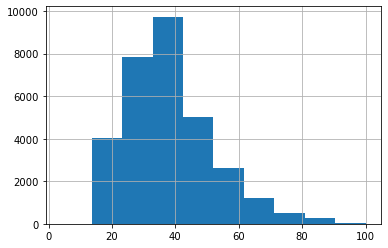

In [36]:
# Tramificacion de edades
age_tram = df[df['pk_partition']=='2018-05-28']['age']
age_tram.hist()

In [37]:
age_divisions = {1:[0,20], 2:[20,40], 3:[40,60], 4:[60,120]}
df['age_tram'] = 0
for div, values in age_divisions.items():
    df['age_tram'] = np.where( (df['age'] > values[0]) & (df['age'] <= values[1]), div, df['age_tram'] )

In [38]:
# Tramificacion de edades
salary_tram = df[df['pk_partition']=='2018-05-28']['salary']
quartiles = salary_tram.describe()
quartiles

count    2.623800e+04
mean     1.180507e+05
std      1.742694e+05
min      7.425000e+03
25%      6.374168e+04
50%      9.170289e+04
75%      1.354168e+05
max      1.326862e+07
Name: salary, dtype: float64

In [39]:
salary_divisions = {1:[0,4e4], 2:[4e4,8e4], 3:[8e4,12e4], 4:[12e4,2e10]}
df['salary'].fillna(-1,inplace=True)

df['salary_tram'] = 0

for div, values in salary_divisions.items():
    print(values)
    df['salary_tram'] = np.where( (df['salary'] > values[0]) & (df['salary'] <= values[1]), div, df['salary_tram'] )

[0, 40000.0]
[40000.0, 80000.0]
[80000.0, 120000.0]
[120000.0, 20000000000.0]


In [40]:
df.fillna(0, inplace=True)

In [41]:
df['pk_partition'] = pd.to_datetime(df['pk_partition'])
df['month'] = df['pk_partition'].dt.month
df['year'] = df['pk_partition'].dt.year

# Preparamos el target 
Observamos que algunos clientes compran varios productos el mismo mes. 
El target que queremos predecir es la compra de un producto por lo que sera 1
En caso de que sean varias compras el mismo mes, se duplicara el número de registros 

In [42]:
df['compras_cuenta'] = np.where(df['altas_cuenta']>=1,1,0) 
df['compras_inversión'] =  np.where(df['altas_inversión']>=1,1,0) 
df['compras_prestamo'] = np.where(df['altas_prestamo']>=1,1,0)

df['compras'] = df['compras_cuenta'] + df['compras_inversión'] + df['compras_prestamo']
max_ = int(max(df['compras'].value_counts().index)+1)
print(max_)

4


In [43]:
print(df['compras_cuenta'].value_counts())
print(df['compras_inversión'].value_counts())
print(df['compras_prestamo'].value_counts())

0    1339574
1      47048
Name: compras_cuenta, dtype: int64
0    1349121
1      37501
Name: compras_inversión, dtype: int64
0    1319380
1      67242
Name: compras_prestamo, dtype: int64


In [44]:
df['compras'].value_counts()

0    1251450
1     119689
2      14347
3       1136
Name: compras, dtype: int64

In [45]:
list_ = products_list.copy()
df['pk_partition'] = pd.to_datetime(df['pk_partition'])
list_.append('pk_partition')
list_.append('pk_cid')

compras_todas = {}

for number in range(1,max_):
    part_df = df[df['compras'] == number][list_].set_index(['pk_cid','pk_partition'])

    #print(part_df[list_products] != 0)
    for key, row in part_df.iterrows():
        #print(key, row[row != 0].index.to_list())
        compras_todas[key] = row[row != 0].index.to_list()     
        
    print(number)
    #for num in range(1,number+1):
    #    df['prod'+str(num)] = np.where( , cost_product[products_dict[prods[num-1]]], df['prod'+str(num)] )

1
2
3


In [46]:
import pickle
f = open("compras_todas.pkl","wb")
pickle.dump(compras_todas,f)
f.close()

In [47]:
compras_df = pd.DataFrame.from_dict(compras_todas, orient='index')

compras_melted = compras_df.melt(ignore_index = False)
compras_melted['tipo_producto'] = compras_melted['value'].replace(products_3)
compras_melted['precio'] = compras_melted['tipo_producto'].replace(product_values)
compras_melted = compras_melted.reset_index()

compras_melted['pk_cid'] = compras_melted['index'].apply( lambda x: x[0] )
compras_melted['pk_partition'] = compras_melted['index'].apply( lambda x: x[1] )

#compras_melted = compras_melted[~compras_melted['pk_partition'].isna()]
compras_melted = compras_melted[~compras_melted['tipo_producto'].isna()]

compras_melted

#compras_melted[['pk_cid','pk_partition','tipo_producto','precio']]

,index,variable,value,tipo_producto,precio,pk_cid,pk_partition
0,"(16502, 2019-01-28 00:00:00)",0,emc_account,cuenta,10.0,16502,2019-01-28
1,"(17457, 2018-10-28 00:00:00)",0,em_acount,cuenta,10.0,17457,2018-10-28
2,"(17457, 2019-01-28 00:00:00)",0,long_term_deposit,inversión,40.0,17457,2019-01-28
3,"(17457, 2019-03-28 00:00:00)",0,long_term_deposit,inversión,40.0,17457,2019-03-28
4,"(17457, 2019-05-28 00:00:00)",0,long_term_deposit,inversión,40.0,17457,2019-05-28
...,...,...,...,...,...,...,...
975348,"(1128353, 2018-11-28 00:00:00)",7,debit_card,prestamo,60.0,1128353,2018-11-28
986723,"(1190607, 2018-04-28 00:00:00)",7,em_acount,cuenta,10.0,1190607,2018-04-28
1005016,"(1265402, 2018-09-28 00:00:00)",7,debit_card,prestamo,60.0,1265402,2018-09-28
1066624,"(1018436, 2018-05-28 00:00:00)",7,em_acount,cuenta,10.0,1018436,2018-05-28


In [48]:
compras_melted.info()
compras_melted['pk_partition'] = compras_melted['pk_partition'].apply(lambda x: str(x)[:11])
df['pk_partition'] = df['pk_partition'].apply(lambda x: str(x)[:11])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311491 entries, 0 to 1069708
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   index          311491 non-null  object        
 1   variable       311491 non-null  int64         
 2   value          311491 non-null  object        
 3   tipo_producto  311491 non-null  object        
 4   precio         311491 non-null  float64       
 5   pk_cid         311491 non-null  int64         
 6   pk_partition   311491 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 19.0+ MB


In [49]:
del compras_todas, compras_df, part_df

In [50]:
df = pd.merge(df, compras_melted[['pk_cid','pk_partition','value','tipo_producto','precio']], on=['pk_cid','pk_partition'], how='left')
del compras_melted

## Precio de productos
De los 14 productos que tenmos los hemos agrupado en 3 variables, cada una tiene un precio 10, 40 y 60 euros. Queremos trabajar un modelo general con todos los productos, se puede entender que un cliente, compre prductos de menor coste.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566404 entries, 0 to 1566403
Data columns (total 72 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   pk_cid                          1566404 non-null  int64  
 1   pk_partition                    1566404 non-null  object 
 2   short_term_deposit              1566404 non-null  bool   
 3   loans                           1566404 non-null  bool   
 4   mortgage                        1566404 non-null  bool   
 5   funds                           1566404 non-null  bool   
 6   securities                      1566404 non-null  bool   
 7   long_term_deposit               1566404 non-null  bool   
 8   em_account_pp                   1566404 non-null  bool   
 9   credit_card                     1566404 non-null  bool   
 10  payroll                         1566404 non-null  bool   
 11  pension_plan                    1566404 non-null  bool   
 12  

In [52]:
df['precio'].value_counts(dropna=False)

NaN     1254913
10.0     151399
60.0      99999
40.0      60093
Name: precio, dtype: int64

In [53]:
df['precio'] = np.where(df['precio'].isna(),0,df['precio'])
#df['value'] = np.where(df['value'].isna(),0,df['value'])

In [54]:
df['value'].value_counts(dropna=False)


NaN                   1254913
debit_card              85584
em_acount               71216
payroll_account         51557
pension_plan            46029
emc_account             28618
credit_card             14302
long_term_deposit        7058
securities               2600
short_term_deposit       2493
funds                    1913
loans                      83
mortgage                   30
em_account_p                8
Name: value, dtype: int64

In [55]:
df['id'] = range(df.shape[0])

In [56]:
cost_10 = set(list(df['id'].sample(int(df.shape[0]*0.35))))
cost_60 = set(list(df['id'].sample(int(df.shape[0]*0.35))))

print(len(cost_10))
print(len(cost_60))

548241
548241


In [57]:
df['precio'].fillna(0,inplace=True)
df['precio'] = np.where( (df['precio'] == 0) & (df['id'].isin(cost_10)), 10, df['precio'])
df['precio'] = np.where( (df['precio'] == 0) & (df['id'].isin(cost_60)), 60, df['precio'])
df['precio'] = np.where( df['precio'] == 0, 40, df['precio'])

In [58]:
print(df['precio'].value_counts(dropna=False))
df.drop('id',axis=1,inplace=True)

10.0    590802
40.0    590010
60.0    385592
Name: precio, dtype: int64


# Limpiamos la Data
En esta variable limpiamos los nulos y las columnas que no son relevantes para nuestro modelo.

In [59]:
df['compras'] = np.where(df['compras']>=1,1,0)

In [60]:
df[['compras','precio']].value_counts()

compras  precio
0        40.0      528457
         10.0      438187
         60.0      284806
1        10.0      152615
         60.0      100786
         40.0       61553
dtype: int64

In [61]:
df.shape

(1566404, 72)

In [62]:
for x in products_list:
    df.drop(x, axis=1, inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566404 entries, 0 to 1566403
Data columns (total 58 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   pk_cid                          1566404 non-null  int64  
 1   pk_partition                    1566404 non-null  object 
 2   payroll                         1566404 non-null  bool   
 3   entry_date                      1566404 non-null  object 
 4   entry_channel                   1566404 non-null  int64  
 5   active_customer                 1566404 non-null  float64
 6   segment                         1566404 non-null  object 
 7   country_id                      1566404 non-null  object 
 8   region_code                     1566404 non-null  float64
 9   gender                          1566404 non-null  int64  
 10  age                             1566404 non-null  int64  
 11  deceased                        1566404 non-null  object 
 12  

In [64]:
remove_cols = ['value','tipo_producto','segment','payroll','country_id','region_code','pk_partition',
               'entry_date','deceased','compra_antes','total','total_altas','total_altas_cuenta',
               'total_altas_prestamo','total_altas_ahorros','altas_ahorros','altas_cuenta','altas_prestamo']

for col in remove_cols:
    try:
        df.drop(col, axis=1, inplace=True)
    except:
        pass

In [65]:
df.columns.to_list()

['pk_cid',
 'entry_channel',
 'active_customer',
 'gender',
 'age',
 'salary',
 'altas_inversión',
 'total_bajas_1m_shift',
 'total_bajas_3m_shift',
 'total_bajas_cuenta_1m_shift',
 'total_bajas_cuenta_3m_shift',
 'total_bajas_inversión_1m_shift',
 'total_bajas_inversión_3m_shift',
 'total_bajas_prestamo_1m_shift',
 'total_bajas_prestamo_3m_shift',
 'total_altas_1m_shift',
 'total_altas_2m_shift',
 'total_altas_3m_shift',
 'total_altas_6m_shift',
 'total_altas_cuenta_1m_shift',
 'total_altas_cuenta_2m_shift',
 'total_altas_cuenta_3m_shift',
 'total_altas_cuenta_6m_shift',
 'total_altas_inversión_1m_shift',
 'total_altas_inversión_2m_shift',
 'total_altas_inversión_3m_shift',
 'total_altas_inversión_6m_shift',
 'total_altas_prestamo_1m_shift',
 'total_altas_prestamo_2m_shift',
 'total_altas_prestamo_3m_shift',
 'total_altas_prestamo_6m_shift',
 'cuentas_fans',
 'inversión_fans',
 'prestamo_fans',
 'fans',
 'tiempo_ult_compra',
 'age_tram',
 'salary_tram',
 'month',
 'year',
 'compras_cu

In [66]:
df.isnull().sum()[ df.isnull().sum() != 0 ]

Series([], dtype: int64)

In [67]:
df.fillna(0, inplace=True)

In [68]:
targets = ['compras','compras_cuenta','compras_inversión','compras_prestamo']

# Preparamos los datos para la predicción
Realizamos predicción de los clientes y guardamos nuevo dataset con la pedicción "prediction_clients.csv"


In [69]:
if PREPARE_PREDICTION:
    df_prediction = df[(df['year']==2019)&(df['month']==5)]
    df_prediction = df_prediction.groupby('pk_cid').last()
    
    df_prediction['tiempo_ult_compra'] += 1
    df_prediction['tiempo_ult_compra'] = np.where(df_prediction['compras']>1, 1, df_prediction['tiempo_ult_compra'])

    df_prediction['month'] += 1

    pred_features = df_prediction.columns.to_list()

    for item in targets+remove_cols:
        try:
            pred_features.remove(item)
        except:
            pass

    df_prediction[pred_features].to_csv(data+'prediction_clients.csv')

    assert 1 != 0 #must finish

# Contrucción de modelo 
Construiremos 4 modelos de predicción, 
- general
- cuentas
- inversión
- prestamos

Tenemos que balancear el dataset, ya que esto resulta más complicado para predecir datos
- Undersampling. En este caso se aumenta el número de registros de la clase minoritaria.
- Oversampling En este caso se reduce el número de registros de la clase mayoritaria, de manera que la distribución no sea tan desproporcionada.

In [70]:
def balancear_dataset(df, target, dist, totales, tipo, times=1):
    totales_ = totales.copy()
    
    compras = ['compra_inversión','compra_cuenta','compra_prestamo']
    boolean = False
    if target in compras:
        compras.remove(target)
        boolean = True
    
    subset_positives = df[ (df[target]==True) ]
    df_ = subset_positives.copy(deep=True)
    
    if boolean:
        df = df[(df[compras[0]]==False) & (df[compras[1]]==False)]
    
    if tipo == 'undersampling':
        subset_negatives = df[ (df[target] == 0) ].sample( df_.shape[0]*dist )
    elif tipo == 'oversampling':
        for time in range(times-1):
            df_ = df_.append( subset_positives, ignore_index=True )
        if dist == 0:
            subset_negatives = df[ (df[target] == 0) ]
        else:
            subset_negatives = df[ (df[target] == 0) ].sample( df_.shape[0]*dist )
    df_final = subset_negatives.copy(deep=True)
    df_final = df_final.append( df_, ignore_index=True )
    
    totales_.remove(target)
    #print(totales_)
        
    df_final.drop(totales_, axis='columns', inplace=True)
    
    del totales_
    
    return df_final

In [71]:
def dataset_split(df_final, target, balanceo, totales, dist, times=1):
    features = df_final.columns.to_list()  
    X = df_final[ features ]
    y = df_final[ target ]

    X_validation = X[(X['year']==2019) & (X['month']==5)]
    y_validation = y.loc[X_validation.index]
    
    #X_train_test = X[(X['year']!=2019) & (X['month']!=5)]
    #y_train_test = y.loc[X_train_test.index]
    
    # Balancear dataset 
    df_balanceo = balancear_dataset(df_final, target, dist, totales, "oversampling", times)
    
    features = df_balanceo.columns.to_list()
    remove_cols = ['country_id','compra_antes',target]
    for x in remove_cols:
        try:
            features.remove(x)
        except:
            pass
    
    X_train_test = df_balanceo[ features ]
    y_train_test = df_balanceo[ target ]
    X_validation = X_validation[ features ]
    
    # Train and Test
    X_train, X_test, y_train, y_test =  train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=42)
    
    return X_train, y_train, X_test, y_test, X_validation, y_validation 
    

In [72]:
def metricas(y_test, y_pred, y_test_score, y_train, y_train_pred, y_train_score):
    print("----------- TEST -----------")
    print("Accuracy:",accuracy_score(y_test, y_pred))
    print("Precision:",precision_score(y_test, y_pred))
    print("Recall:",recall_score(y_test, y_pred))
    print("F1-score:",f1_score(y_test, y_pred))
    print("ROC AUC score:",roc_auc_score(y_test, y_test_score))
    print("----------- TRAIN -----------")
    print("Accuracy:",accuracy_score(y_train, y_train_pred))
    print("Precision:",precision_score(y_train, y_train_pred))
    print("Recall:",recall_score(y_train, y_train_pred))
    print("F1-score:",f1_score(y_train, y_train_pred))
    print("ROC AUC score:",roc_auc_score(y_train, y_train_score))

In [73]:
def confusion_matrix_figure(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(8,8))

    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix_ = cf_matrix.copy()
    cf_matrix_[1,1] = cf_matrix[0,0]
    cf_matrix_[0,1] = cf_matrix[1,0]
    cf_matrix_[0,0] = cf_matrix[1,1]
    cf_matrix_[1,0] = cf_matrix[0,1]
    cf_matrix_

    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix_.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix_, annot=labels, fmt='', cmap='Greens', annot_kws={"size": 20},
                    yticklabels=['Positive','Negative'], xticklabels=['Positive','Negative'])
    ax.set_xlabel('Predicted',fontsize=23)
    ax.set_ylabel('Real',fontsize=23)
    ax.tick_params(labelsize=20)
    
    return fig

## Modelo General 
Con este modelo vamos a predecir la compra de cualquier varible de producto, las ventajas de este se basan en un dataset con mas variables a tener encuenta para predecir, al tener mas información y estar balanceado tiene un mayor acierto.


In [74]:
df['compras'].value_counts()

0    1251450
1     314954
Name: compras, dtype: int64

In [75]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras', "oversampling", targets, dist=0, times=1)

features = X_train.columns.to_list()
features.remove('pk_cid')
#features.remove('cluster')

In [76]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1253123
0    0.799243
1    0.200757
Name: compras, dtype: float64 

TEST:  313281
0    0.797686
1    0.202314
Name: compras, dtype: float64 

VALIDATION:  175077
0    0.838248
1    0.161752
Name: compras, dtype: float64


## Visualizamos el modelo con un arbol de clasificación

In [77]:
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=350, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

In [78]:
metricas(y_test, y_pred, y_test_score, y_train, y_train_pred, y_train_score)

----------- TEST -----------
Accuracy: 0.8792713251042993
Precision: 0.841780107512503
Recall: 0.49659992742304476
F1-score: 0.6246774897789068
ROC AUC score: 0.9068860860953458
----------- TRAIN -----------
Accuracy: 0.8806805078192643
Precision: 0.8441924625793439
Recall: 0.4974659442785991
F1-score: 0.6260267120204092
ROC AUC score: 0.911424618297578


----------- VALIDATION -----------
Accuracy: 0.9024886192932252
Precision: 0.8600883652430045
Recall: 0.4743105335640383
F1-score: 0.6114348142753095
ROC AUC score: 0.9200143035588764


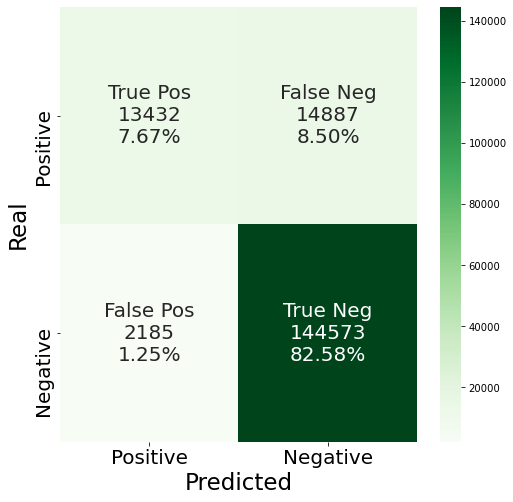

In [79]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

fig = confusion_matrix_figure(y_validation, y_pred_valida)
fig.show()

Al evaluar el modelo de validación y verlo con la confusion_matrix, vemos eque el ROC AUC score es alto debido al balanceo de los datos, el fallo del modelo esta en el bajo recall y precisión, ya que le cuesta dar positivos.

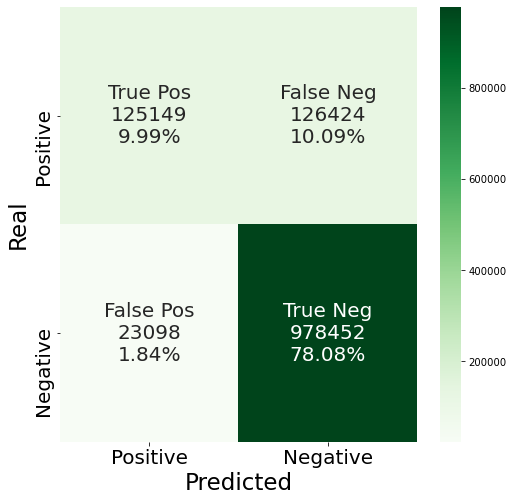

In [80]:
fig = confusion_matrix_figure(y_train, y_train_pred)

In [81]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [82]:
pd.Series( model.feature_importances_, index=features ).sort_values(ascending=False).head(30)

altas_inversión                   0.548435
total_altas_1m_shift              0.111214
precio                            0.089657
entry_channel                     0.059078
tiempo_ult_compra                 0.058244
active_customer                   0.048088
total_bajas_inversión_1m_shift    0.024777
age                               0.023864
total_altas_cuenta_1m_shift       0.006660
month                             0.005707
salary                            0.004893
total_altas_inversión_1m_shift    0.004801
total_bajas_1m_shift              0.004349
total_altas_prestamo_1m_shift     0.004058
total_bajas_cuenta_1m_shift       0.002165
gender                            0.000880
total_bajas_prestamo_1m_shift     0.000673
year                              0.000584
total_altas_6m_shift              0.000575
total_altas_cuenta_6m_shift       0.000462
total_altas_prestamo_6m_shift     0.000213
total_altas_inversión_6m_shift    0.000196
fans                              0.000113
age_tram   

# Modelo Cuentas

Este modelo al contar con pocos datos se balance, aun así al tener poca información el modelo predice pocas compras.

In [83]:
df['compras_cuenta'].value_counts()

0    1468397
1      98007
Name: compras_cuenta, dtype: int64

In [84]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras_cuenta', "oversampling", targets, dist=0, times=2)

features = X_train.columns.to_list()
features.remove('pk_cid')
features.remove('precio')

In [85]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1331528
0    0.882275
1    0.117725
Name: compras_cuenta, dtype: float64 

TEST:  332883
0    0.882061
1    0.117939
Name: compras_cuenta, dtype: float64 

VALIDATION:  175077
0    0.946275
1    0.053725
Name: compras_cuenta, dtype: float64


In [86]:
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 0.9485712001005272
Precision: 0.5331902245706737
Recall: 0.3432915160535828
F1-score: 0.4176691243047472
ROC AUC score: 0.8938306150276217


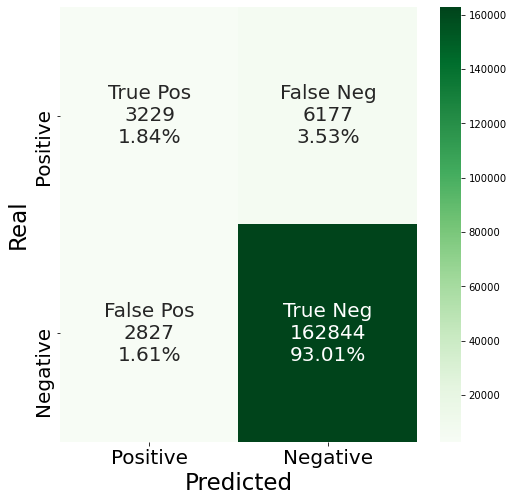

In [87]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

#fig = confusion_matrix_figure(y_train, y_train_pred)
fig = confusion_matrix_figure(y_validation, y_pred_valida)

In [ ]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

IndentationError: unexpected indent (3021465641.py, line 2)

# Modelo inversión 
Un caso similar a los modelos anteriores, se debe balancear, pocos datos y le cuesta predecir compras

In [88]:
df['compras_inversión'].value_counts()

0    1471539
1      94865
Name: compras_inversión, dtype: int64

In [89]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras_inversión', "oversampling", targets, dist=0, times=2)

features = X_train.columns.to_list()
features.remove('pk_cid')
features.remove('precio')

In [90]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1329015
0    0.885865
1    0.114135
Name: compras_inversión, dtype: float64 

TEST:  332254
0    0.8855
1    0.1145
Name: compras_inversión, dtype: float64 

VALIDATION:  175077
0    0.956419
1    0.043581
Name: compras_inversión, dtype: float64


In [91]:
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC score: 1.0


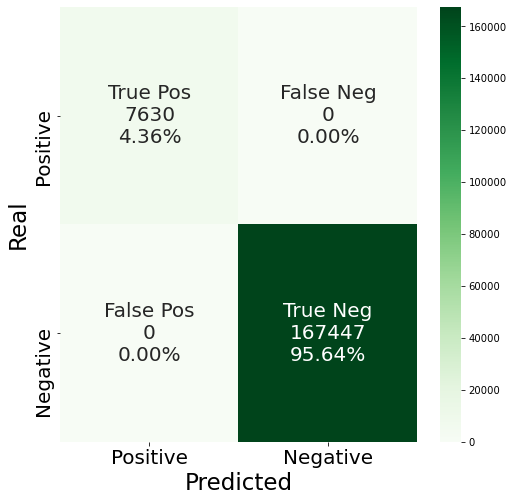

In [92]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

#fig = confusion_matrix_figure(y_train, y_train_pred)
fig = confusion_matrix_figure(y_validation, y_pred_valida)

In [ ]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

IndentationError: unexpected indent (3021465641.py, line 2)

# Modelo Prestamos 

In [93]:
df['compras_prestamo'].value_counts()

0    1400525
1     165879
Name: compras_prestamo, dtype: int64

In [94]:
X_train, y_train, X_test, y_test, X_validation, y_validation = \
    dataset_split(df, 'compras_prestamo', "oversampling", targets, dist=0, times=2)

features = X_train.columns.to_list()
features.remove('pk_cid')
features.remove('precio')
#features.remove('cluster')

In [95]:
print('TRAIN: ',y_train.shape[0]) 
print(y_train.value_counts(normalize=True),'\n')

print('TEST: ', y_test.shape[0])
print(y_test.value_counts(normalize=True),'\n')

print('VALIDATION: ',y_validation.shape[0])
print(y_validation.value_counts(normalize=True))

TRAIN:  1385826
0    0.808352
1    0.191648
Name: compras_prestamo, dtype: float64 

TEST:  346457
0    0.809018
1    0.190982
Name: compras_prestamo, dtype: float64 

VALIDATION:  175077
0    0.916197
1    0.083803
Name: compras_prestamo, dtype: float64


In [96]:
model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=500, random_state=42 )

model.fit(X_train[features],y_train)

y_train_pred = model.predict(X_train[features])
y_train_score = model.predict_proba(X_train[features])[:,1]

#Predict the response for test dataset
y_pred = model.predict(X_test[features])
y_test_score = model.predict_proba(X_test[features])[:,1]

----------- VALIDATION -----------
Accuracy: 0.9245417730484301
Precision: 0.5921301551267499
Recall: 0.3199972737186478
F1-score: 0.4154683421087562
ROC AUC score: 0.8616999533572276


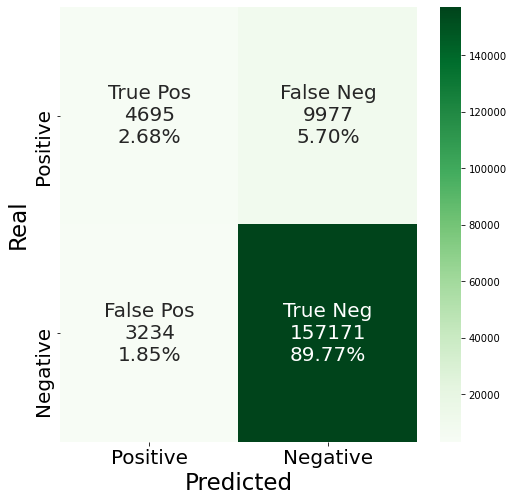

In [97]:
y_pred_valida = model.predict(X_validation[features])
y_valida_score = model.predict_proba(X_validation[features])[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(y_validation, y_pred_valida))
print("Precision:",precision_score(y_validation, y_pred_valida))
print("Recall:",recall_score(y_validation, y_pred_valida))
print("F1-score:",f1_score(y_validation, y_pred_valida))
print("ROC AUC score:",roc_auc_score(y_validation, y_valida_score))

#fig = confusion_matrix_figure(y_train, y_train_pred)
fig = confusion_matrix_figure(y_validation, y_pred_valida)

In [ ]:
tree_data = export_graphviz(
    decision_tree = model,
    out_file=None,
    #*,
    max_depth=3,
    feature_names= features,
    class_names=['No Compra','Compra'],
    #label='all',
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
)

graph = graphviz.Source(tree_data, format='png')
graph

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

# Conclusión

En conclusión nos quedamos con el modelo general, ya que tiene mayor información, esta más balanceado y esto hace que tenga una mayor predicción de compra.
A futuro es un modelo que se podría mejorar, ya que solo contamos con variables estacionarias y este ha limitado muchas información de mejora para el modelo.